# Background

Links:
- [RuleFit paper](http://statweb.stanford.edu/~jhf/ftp/RuleFit.pdf)
- [Interpretable ML - RuleFit](https://christophm.github.io/interpretable-ml-book/rulefit.html)
- [RuleFit GitHub](https://github.com/christophM/rulefit) 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rulefit import RuleFit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

plt.style.use("../style.mplstyle")

In [2]:
data = pd.read_csv("../data/cardio.csv", sep=";", index_col=0)
X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values
print(f"Number of records         : {X.shape[0]}")
print(f"Number of features        : {X.shape[1]}")
print(f"Count of positive outcomes: {sum(y)} ({sum(y)/len(y)*100:.1f}%)")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
data.sample(10)

Number of records         : 70000
Number of features        : 11
Count of positive outcomes: 34979 (50.0%)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
74067,20494,2,166,70.0,120,70,1,2,1,0,1,0
56660,19897,2,165,80.0,110,80,2,1,0,0,1,0
83564,21856,1,168,69.0,120,80,1,1,0,0,1,1
86492,20724,1,164,80.0,110,80,1,1,0,0,1,0
2096,18051,1,168,66.0,120,80,1,1,0,0,1,1
30398,19831,2,177,79.0,140,90,1,1,0,0,0,1
52489,19810,1,160,55.0,120,80,1,1,0,0,1,1
92549,20185,1,165,61.0,120,80,3,3,0,0,1,0
4792,20473,1,160,75.0,110,80,1,1,0,0,0,0


In [3]:
gb = GradientBoostingClassifier(n_estimators=100, max_depth=10)
rf = RuleFit(tree_generator=gb, rfmode='classify')
rf.fit(X_train, y_train, feature_names=data.columns[:-1])

RuleFit(max_iter=1000, rfmode='classify',
        tree_generator=GradientBoostingClassifier(max_depth=10,
                                                  max_leaf_nodes=9,
                                                  n_estimators=574,
                                                  random_state=573))

In [4]:
# score of standard GBT
gb.fit(X_train, y_train)
print(roc_auc_score(y_test, gb.predict(X_test)))
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb.predict_proba(X_test)[:, 1])

0.7361729547603343


In [5]:
# score of RuleFit
print(roc_auc_score(y_test, rf.predict(X_test)))
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])

0.7290739273165923


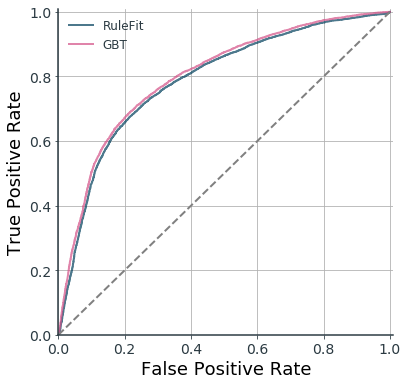

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr, label="RuleFit", alpha=0.7)
ax.plot(fpr_gb, tpr_gb, label="GBT", alpha=0.7)
ax.plot([0, 1], [0, 1], linestyle='--', c="grey")
ax.set_xlim([0, 1.01])
ax.set_ylim([0, 1.01])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()
ax.grid();

In [7]:
rules = rf.get_rules()
rules = rules[rules.coef != 0].sort_values("support", ascending=False)
rules.head(20)

,rule,type,coef,support,importance
0,age,linear,-0.000034,1.000000,0.083161
2,height,linear,-0.001577,1.000000,0.011764
3,weight,linear,-0.013485,1.000000,0.178342
4,ap_hi,linear,-0.002993,1.000000,0.047916
5,ap_lo,linear,-0.006526,1.000000,0.060067
6,cholesterol,linear,0.022552,1.000000,0.015329
7,gluc,linear,-0.029212,1.000000,0.016660
8,smoke,linear,-0.132408,1.000000,0.037726
9,alco,linear,-0.021622,1.000000,0.004931
10,active,linear,0.032946,1.000000,0.013093


In [8]:
rules.sort_values("importance", ascending=False).head(15)

,rule,type,coef,support,importance
1025,ap_hi <= 133.5 & cholesterol > 2.5,rule,-1.960090,0.062762,0.475389
141,cholesterol > 2.5 & ap_hi <= 132.5,rule,1.505977,0.062743,0.365199
1164,ap_hi > 125.5 & age > 17748.0 & age > 17761.5,rule,0.723535,0.336514,0.341883
693,ap_hi <= 136.5 & gluc <= 2.5 & cholesterol > 2.5,rule,1.874741,0.033162,0.335690
606,ap_lo > 7.5 & ap_hi <= 40.0,rule,5.796832,0.002667,0.298948
151,ap_hi <= 138.5 & cholesterol > 2.5,rule,-1.169012,0.063619,0.285324
83,weight > 73.0999984741211 & ap_hi <= 126.5 & c...,rule,-2.025862,0.017448,0.265250
442,age > 23637.0 & age > 23628.5 & weight <= 77.0,rule,9.598120,0.000705,0.254715
1017,weight > 73.0999984741211 & ap_hi <= 129.0 & c...,rule,1.926784,0.017467,0.252413
471,ap_hi <= 138.5 & ap_lo <= 96.5 & cholesterol >...,rule,-1.547253,0.024800,0.240621
